In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import DataGrabber

from pyro.infer import Predictive

In [36]:


dg = DataGrabber()

outcome_dataset = 'unemployment_rate'
intervention_dataset = 'spending_HHS'
intervention_variable = 'total_obligated_amount'

dg.get_features_std_long([outcome_dataset, intervention_dataset]) 
dg.get_features_std_wide([outcome_dataset, intervention_dataset]) 

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])


forward_shift = 2

outcome_df[f'y_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips]
    # Shift the 'Value' column two years ahead and assign it to the new column
    geo_subset[f'y_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-2)
    geo_subsets.append(geo_subset)
    # Update the original DataFrame with the updated values
    #df.update(geo_subset)

# Reset the index
#df = df.reset_index(drop=True)


display(outcome_df.head())



,GeoFIPS,GeoName,Year,Value,y_shifted_by_2
0,1001,"Autauga County, AL",1990,0.008721,None
3074,1001,"Autauga County, AL",1991,-0.048387,None
6148,1001,"Autauga County, AL",1992,-0.151515,None
9222,1001,"Autauga County, AL",1993,-0.169492,None
12296,1001,"Autauga County, AL",1994,-0.240000,None


In [ ]:

#outcome = dg.std_long[outcome_dataset][(dg.std_long[outcome_dataset]['Year'] >= year_min) & (dg.std_long[outcome_dataset]['Year'] <= year_max + forward_shift)]
#intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]

#display(outcome.head())
# available time units for both intervention and outcome
T_outcome = year_max - year_min + 1

#TODO add covariates
data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in data.columns:
    data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = data.filter(regex=r'^GeoName_[a-zA-Z]$')
    data.drop(columns=columns_to_drop.columns, inplace=True)


data.rename(columns={'Value': outcome_dataset}, inplace=True)

data['state'] = [code // 1000 for code in data['GeoFIPS']]

N_states = len(data['state'].unique())

data['unit_index']= pd.factorize(data['GeoFIPS'].values)[0]
data['state_index']= pd.factorize(data['state'].values)[0]
data['time_index']= pd.factorize(data['Year'].values)[0]

data['y'] = data[outcome_dataset].values.copy()

display(data.head())

y = torch.tensor(data['y'])
unit_index = torch.tensor(data['unit_index'])
state_index = torch.tensor(data['state_index'])
time_index = torch.tensor(data['time_index'])
intervention = torch.tensor(data[intervention_variable])


beta = pyro.sample('beta', dist.Normal(0, 1).expand([T_outcome]))


In [3]:
def cities_model_A(T_outcome, N_states, state_index, time_index, intervention,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", T_outcome):
                beta = pyro.sample("beta", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_states):
                alpha = pyro.sample("alpha", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                y_mean = mu  + beta[time_index]  + alpha[state_index] + tau * intervention
                pyro.sample("y", dist.Normal(y_mean, sigma))

        return  #y_mean, mu, beta, tau, alpha

cities_model_A(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
time_index = time_index, intervention = intervention, y = None)



/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

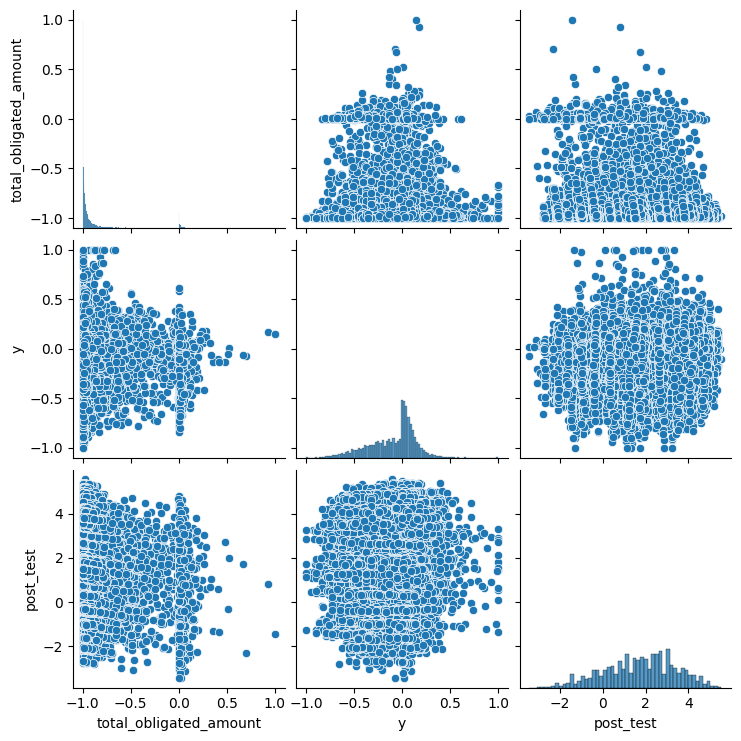

In [4]:
def plot_predictive(model,T_outcome, N_states, state_index, time_index, intervention, guide=None):

    model = condition(data=dict(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention))(model)
    
    #if guide:
    #    guide_tr = pyro.poutine.trace(guide).get_trace()
    #    model_tr = pyro.poutine.trace(pyro.poutine.replay(model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
    #                            time_index = time_index, intervention = intervention), trace=guide_tr)).get_trace()
    #else:
    with pyro.poutine.trace() as tr:
        model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

    model_tr = tr.trace

    y = model_tr.nodes['y']['value']

    data_copy = data.copy()
    data_copy["source"] = "data"

    predictive_copy = data.copy()
    predictive_copy['post_test'] = y.reshape(-1, 1).detach().numpy()  
    predictive_copy["source"] = "predictive"

    sns.pairplot(predictive_copy[['total_obligated_amount', 'y', 'post_test']])
    
    
plot_predictive(cities_model_A, T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

In [19]:

pyro.clear_param_store()
guide =  AutoNormal(cities_model_A)

#AutoDelta(cities_model_A)
# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_A,
    guide=guide,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(data)))


In [20]:
predictive = pyro.infer.Predictive(cities_model_A, guide=guide, num_samples=1000, parallel=False)
samples = predictive(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

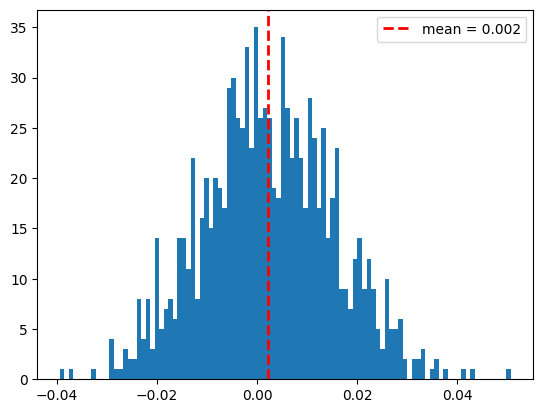

In [26]:
# this is a naive estimate

tau_samples = samples['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()

